# Self Organized Maps (SOMs)

## Import Libraries

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps
# from simpsom.plots import scatter_on_map

# Astropy
from astropy.table import Table

# CuPY
import cupy as cp

# Seaborn
import seaborn as sns

## PCA Whitening and ZPCA Whitening

[Link to Explanation](http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/)

[Link to Visualization](https://setosa.io/ev/principal-component-analysis/)

In [2]:
def pca_whitening(data, epsilon=1e-5):
    '''
    PCA whitening

    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data pca whitened
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

  
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    xPCAwhite = (whitening_matrix @ data_centered.T).T

    return xPCAwhite


def zca_whitening(data, epsilon=1e-5):
    '''
    ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data zca whitened

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_mean0 = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate x_rot and x_tilde
    x_rot = np.dot(data_mean0, eigvecs)

    # Whitening matrix: U * D^{-1/2} * U.T
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Apply whitening
    xZCAwhite = data_mean0 @ whitening_matrix
    
    return xZCAwhite

In [3]:
def inverse_pca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse PCA whitening

    Args:
        original_data: original data
        whitened_data: whitened data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_centered = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    D_sqrt = np.diag(np.sqrt(eigvals + epsilon))

    
    # Calculate the inverse of the PCA whitening matrix
    X_centered = whitened_data @ ((eigvecs @ D_sqrt @ eigvecs.T))
    
    x_dewhitened = X_centered + data_mean.values

    return x_dewhitened


def inverse_zca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_mean0 = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate the inverse of the ZCA whitening matrix
    D = np.diag(np.sqrt(eigvals + epsilon))
    inverse_zca_matrix = eigvecs @ D @ eigvecs.T

    # Apply inverse transform and add mean back
    x_orig = (inverse_zca_matrix @ whitened_data.T).T + data_mean.values

    return x_orig


## Run the SOM

Import the catalog

In [4]:
# RADIUS (3''), EMU (1''), DESY6GOLD (0.1''), VIKINGDR5 (0.1''), CATWISE2020 (0.2''), No MAGNITUDES
# For a false detection rate of <10% 
# p_i>=0.1 & match_flag==1 & p_any>0.83
matched_no_mags_path = '/data/mfonseca/cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_noMags/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag.fits'
matched_no_mags = Table.read(matched_no_mags_path)
matched_no_mags = matched_no_mags.to_pandas()

Filter using NWAY recomendations

In [5]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (matched_no_mags['match_flag'] == 1) & (matched_no_mags['p_i'] >= 0.1) & (matched_no_mags['p_any'] >=0.83)
catalog_matches_noMags = matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

Number of objects in the catalog 11263


Select the objects that have matches in all the three surveys

In [6]:
# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (catalog_matches_noMags['VKG_sourceID'] != -99) & (catalog_matches_noMags['CAT_source_id'] != b'-99')
catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]
print(f'Number of objects in the catalog that have matches in all three surveys {len(catalog_matches_noMags_full)}')

Number of objects in the catalog that have matches in all three surveys 4207


In [7]:
# Filter the multiwavelenght catalog to keep only the columns needed
emu_columns = ['EMU_island_id']

# desdr2_mag = ['DES_mag_auto_g_dered', 'DES_mag_auto_r_dered', 'DES_mag_auto_i_dered', 'DES_mag_auto_z_dered']
# desdr2_colors = ['DES_g_r_dered', 'DES_r_i_dered', 'DES_i_z_dered']

# Technically only need one magnitude to recover the rest from the colors
desy6gold_mag = ['DESY6_mag_auto_g_extcorr', 'DESY6_mag_auto_r_extcorr', 'DESY6_mag_auto_i_extcorr', 'DESY6_mag_auto_z_extcorr', 'DESY6_mag_auto_y_extcorr']
desy6gold_colors = ['DESY6_g_r_extcorr', 'DESY6_r_i_extcorr', 'DESY6_i_z_extcorr', 'DESY6_z_y_extcorr']
desy6gold_features = ['DESY6_dnf_z', 'DESY6_spread_model_g', 'DESY6_spread_model_r', 'DESY6_spread_model_i', 'DESY6_spread_model_z']

viking_mag = ['VKG_zAperMag3_ab_extcorr', 'VKG_jAperMag3_ab_extcorr', 'VKG_yAperMag3_ab_extcorr', 'VKG_ksAperMag3_ab_extcorr', 'VKG_hAperMag3_ab_extcorr']
viking_colors = ['VKG_z_y_am3_extcorr', 'VKG_y_j_am3_extcorr', 'VKG_j_h_am3_extcorr', 'VKG_h_ks_am3_extcorr']
viking_features = ['VKG_mergedClassStat']

catwise_mag = ['CAT_w1mpro_ab', 'CAT_w2mpro_ab']
catwise_colors = ['CAT_w1_w2_ab']

# columns = ([desy6gold_mag[0]] + [viking_mag[0]] + [catwise_mag[0]]) + (desy6gold_colors + viking_colors + catwise_colors) + (desy6gold_features + viking_features)
columns = desy6gold_mag + viking_mag + catwise_mag + desy6gold_features

catalog_som = catalog_matches_noMags_full[columns]


In [18]:
catalog_som_clean = catalog_som[~catalog_som.isin([-999999488.0]).any(axis=1)]
catalog_som_clean = catalog_som_clean[catalog_som_clean['DESY6_mag_auto_g_extcorr'] < 40]
len(catalog_som_clean)

3823

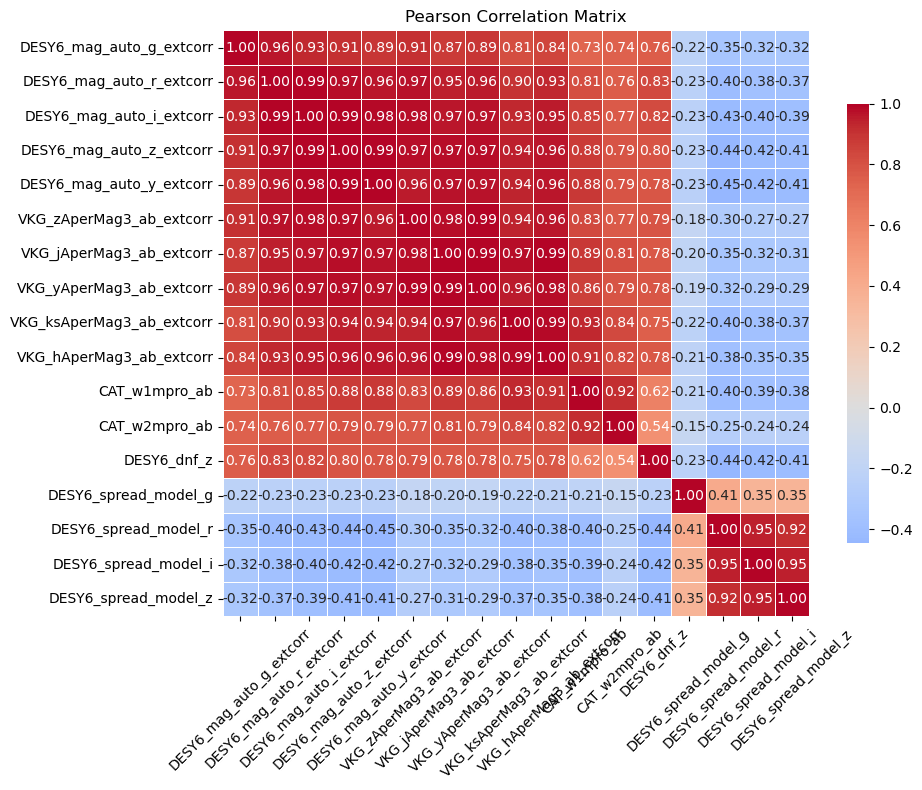

In [37]:
correlation_matrix = catalog_som_clean.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Define the topology of the SOM

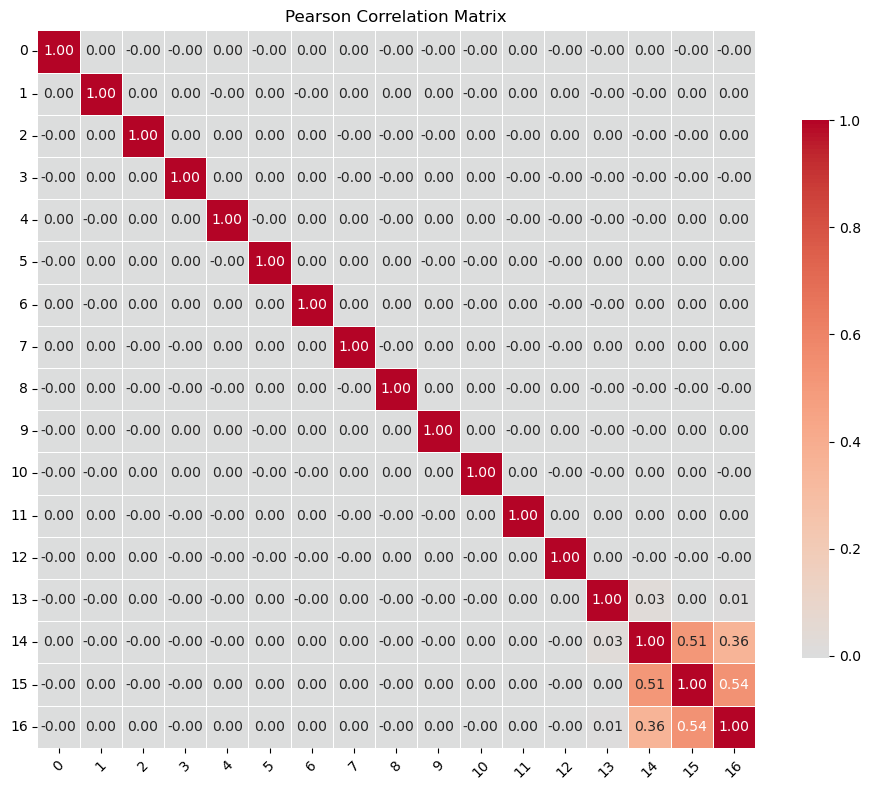

In [41]:
data_fraction2use = 1
data = catalog_som_clean.sample(frac=data_fraction2use)

data.to_numpy()

# for i in columns:
#     plt.hist(data[i], bins=100)
#     plt.title(i)
#     plt.show()

data_white = zca_whitening(data)

# plt.hist(data_white[0], bins=100)
# plt.show()

# data_dewhite = inverse_pca_whitening(data, data_white)
# plt.hist(data_dewhite[0], bins=100)
# plt.show()

correlation_matrix = data_white.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# SOM topology (lattice size)

# Number of sources in our dataframe
inputdata_size = len(data_white)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_matrix = np.cov(data_white, rowvar=False)
eigen_values = np.linalg.eigvals(cov_matrix)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes is 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Resize the SOM map by applying a scaling factor that maintains the aspect ratio

scaling_factor = 2  # Change this factor to resize the map

# Apply scaling to the x dimension, and calculate y dimension based on ratio
som_x_resized = int(som_x * scaling_factor)
som_y_resized = int(som_x_resized / ratio_eigenvalues)  # Keep the same ratio of eigenvalues

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('Ratio of the two largest eigenvalues: ', int(ratio_eigenvalues))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

print('Resized SOM map size using eigenvalues: ', som_x_resized, 'x', som_y_resized)

Dimension of the SOM:  309
Square SOM map size  18.0
Ratio of the two largest eigenvalues:  1
SOM map size using eigenvalues:  17 x 16
Resized SOM map size using eigenvalues:  34 x 33


### Run the SOM

In [ ]:
# Define the SOM
som = sps.SOMNet(
    som_x,
    som_y,
    data_white,
    load_file = None,
    metric= 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = True,
    random_seed = 69,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True,
    output_path = '/data/mfonseca/soms/maps/'
)

som.train(
    train_algo = 'batch', 
    epochs = 100,
    # start_learning_rate = 0.01 , # Used only for online training
    early_stop = None ,
    early_stop_patience = 3 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

2025-05-01 23:14:53.337 | INFO     | simpsom.network:__init__:106 - Periodic Boundary Conditions active.
2025-05-01 23:14:53.338 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2025-05-01 23:14:53.339 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2025-05-01 23:14:53.423 | INFO     | simpsom.network:train:464 - The map will be trained with the batch algorithm.
2025-05-01 23:14:53.436 | INFO     | simpsom.network:save_map:302 - Map shape and weights will be saved to:
/data/mfonseca/soms/maps/trained_som_1epoch.npy
2025-05-01 23:14:53.448 | INFO     | simpsom.network:save_map:302 - Map shape and weights will be saved to:
/data/mfonseca/soms/maps/trained_som_2epoch.npy
2025-05-01 23:14:53.461 | INFO     | simpsom.network:save_map:302 - Map shape and weights will be saved to:
/data/mfonseca/soms/maps/trained_som_3epoch.npy
2025-05-01 23:14:53.473 | INFO     | simpsom.network:save_map:302 - Map shape and weights will be saved to:
/d

2025-05-01 23:14:56.204 | INFO     | simpsom.network:get_nodes_difference:691 - Weights difference among neighboring nodes calculated.


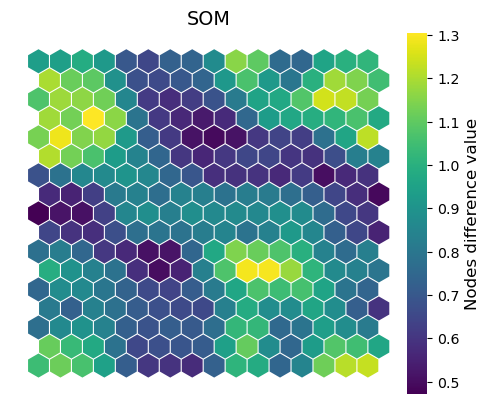

In [53]:
som.plot_map_by_difference(show=True, print_out=False)

## Quantization Error (QE) and Topographic Error (TE)

In [54]:
quantization_error=[]
topographic_error=[]


for i in range(1,10):
    name_file = f'/data/mfonseca/soms/maps/trained_som_' + str(i) + 'epoch'+ '.npy'
    
    # Define the SOM
    sommap = sps.SOMNet(
    17,
    16,
    data_white,
    load_file = name_file,
    )

    # Print the Errors
    quantization_error.append(sommap.calculate_qe())
    topographic_error.append(sommap.calculate_te())

print('Quantization error: ', quantization_error)
print('Topographic error: ', topographic_error)

2025-05-01 23:14:59.017 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2025-05-01 23:14:59.018 | INFO     | simpsom.network:_set_weights:196 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-01 23:14:59.667 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2025-05-01 23:14:59.668 | INFO     | simpsom.network:_set_weights:196 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-01 23:15:00.324 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2025-05-01 23:15:00.325 | INFO     | simpsom.network:_set_weights:196 - The weights will be loaded from file.
The map shape will be overwritten and no weightsinitialization will be applied.
2025-05-01 23:15:00.973 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2025-05-01 23:15:00.974 | INFO     | simpsom.network:_set_weights:196 - The we

Quantization error:  [11.61021900177002, 3.4345500469207764, 3.393489122390747, 3.345722198486328, 3.269394874572754, 3.160356283187866, 3.035576105117798, 2.9141478538513184, 2.794271469116211]
Topographic error:  [1.0, 0.9986921266021449, 0.999738425320429, 0.9981689772430029, 0.9986921266021449, 0.9979074025634319, 0.9981689772430029, 0.9984305519225739, 0.9981689772430029]


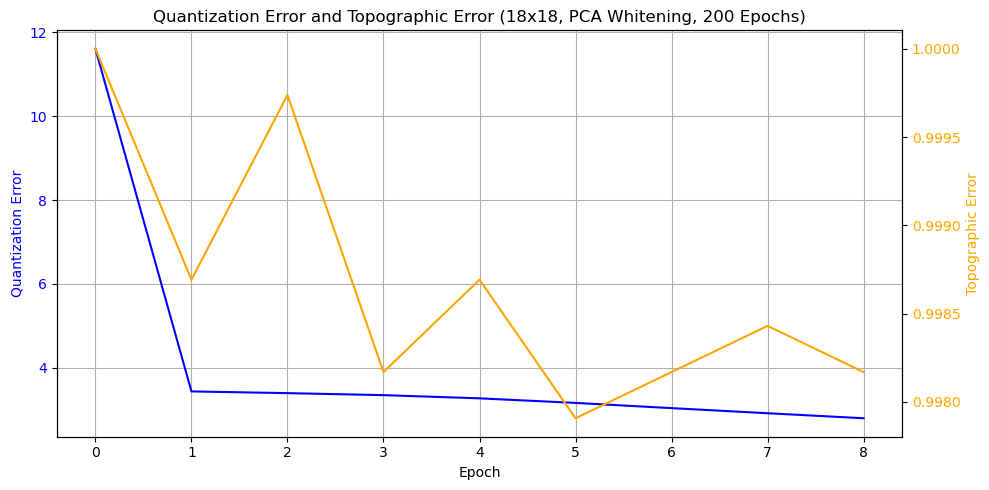

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Quantization Error on the primary y-axis
ax1.plot(quantization_error, label='Quantization Error', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Quantization Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Create a secondary y-axis for Topographic Error
ax2 = ax1.twinx()
ax2.plot(topographic_error, label='Topographic Error', color='orange')
ax2.set_ylabel('Topographic Error', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title('Quantization Error and Topographic Error (18x18, PCA Whitening, 200 Epochs)')
fig.tight_layout()
plt.show()

### Plot value of features

This code plots the values of each feature in each node. Remember that this value is after PCA/ZCA, so it needs to be converted back.

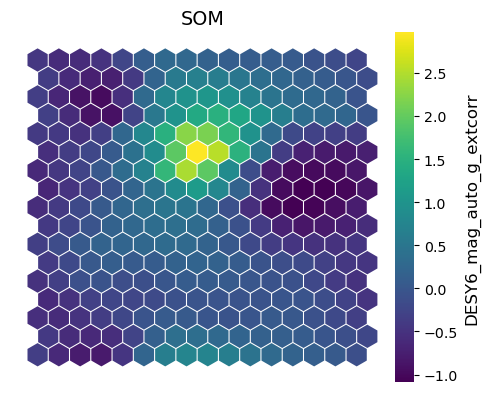

2025-05-01 23:00:28.645 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_0.png


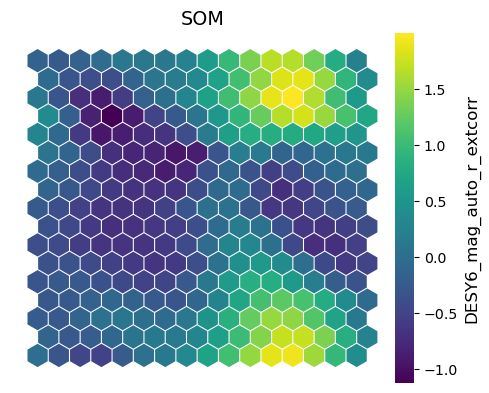

2025-05-01 23:00:28.984 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_1.png


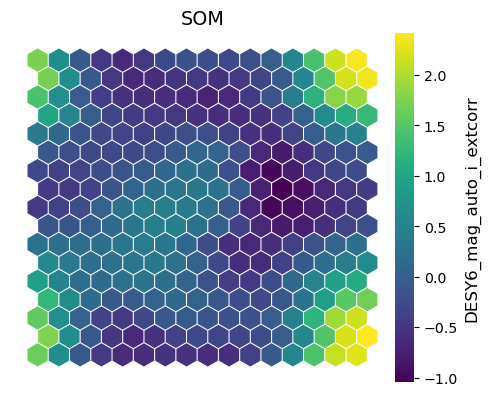

2025-05-01 23:00:29.329 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_2.png


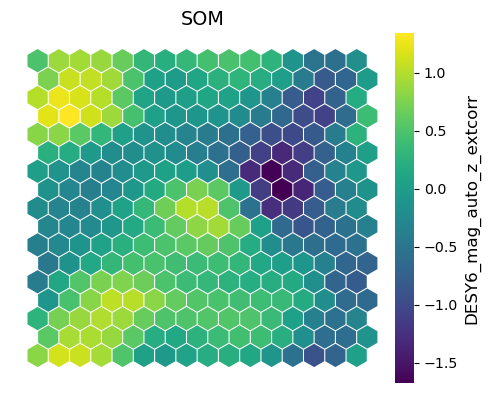

2025-05-01 23:00:29.669 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_3.png


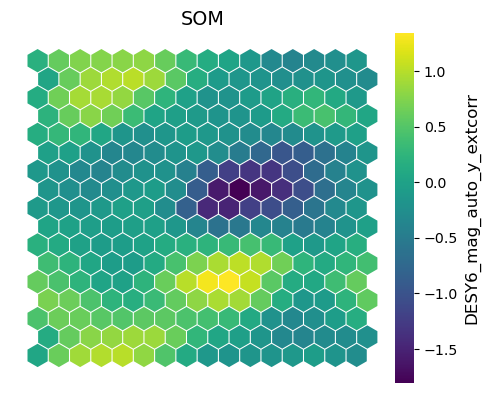

2025-05-01 23:00:30.161 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_4.png


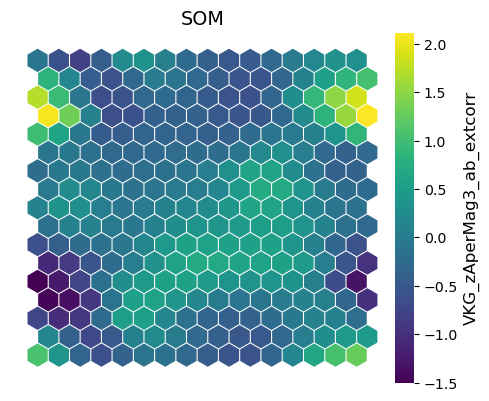

2025-05-01 23:00:30.513 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_5.png


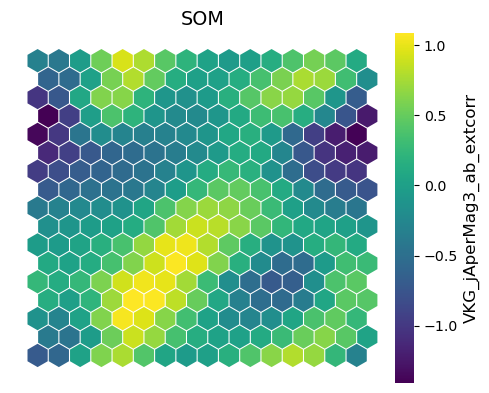

2025-05-01 23:00:30.847 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_6.png


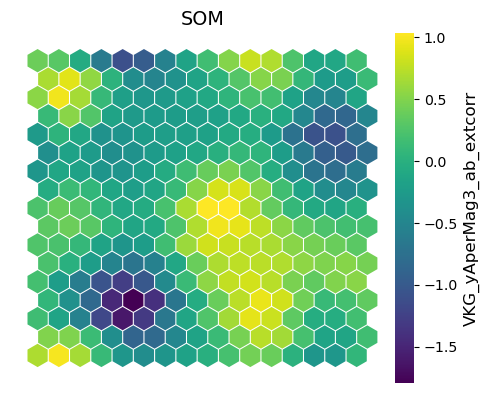

2025-05-01 23:00:31.189 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_7.png


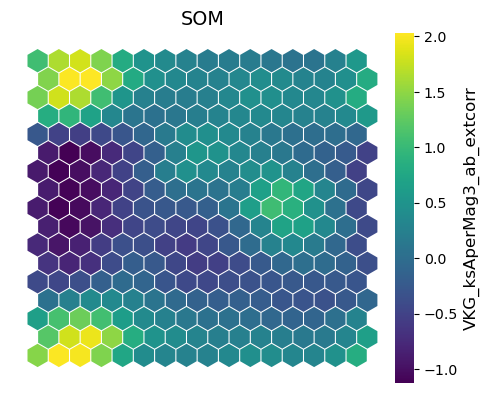

2025-05-01 23:00:31.537 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_8.png


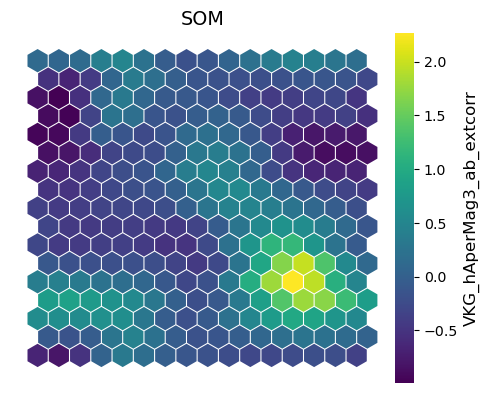

2025-05-01 23:00:31.875 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_9.png


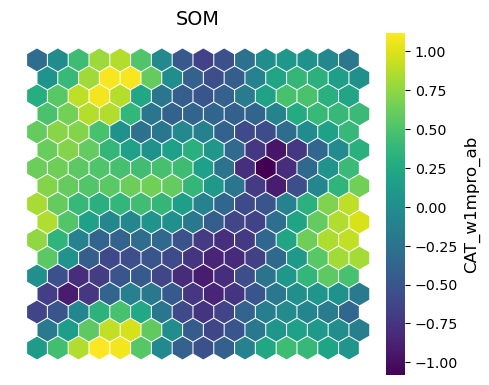

2025-05-01 23:00:32.227 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_10.png


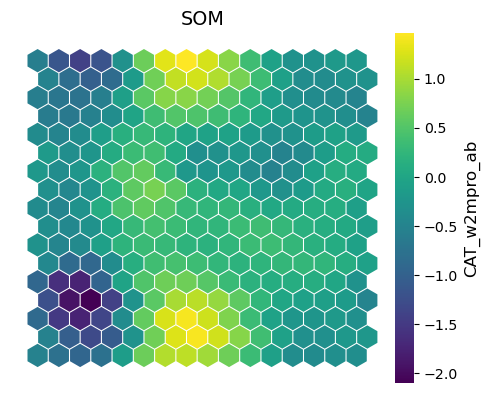

2025-05-01 23:00:32.566 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_11.png


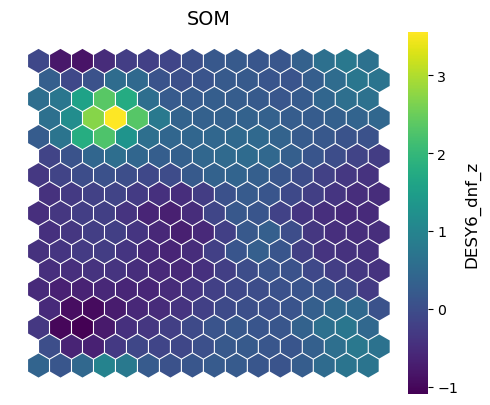

2025-05-01 23:00:32.891 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_12.png


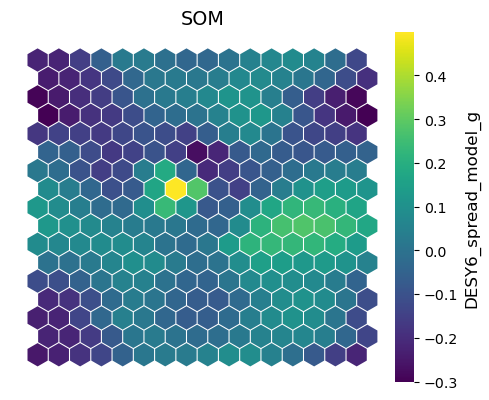

2025-05-01 23:00:33.241 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_13.png


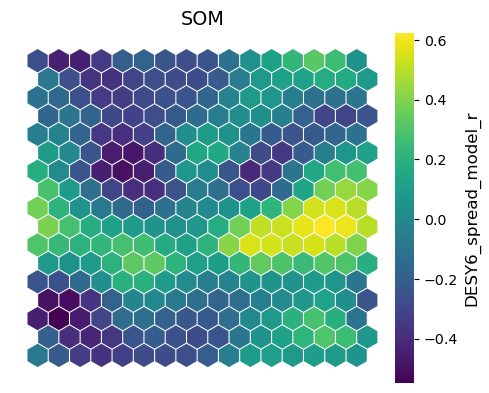

2025-05-01 23:00:33.579 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_14.png


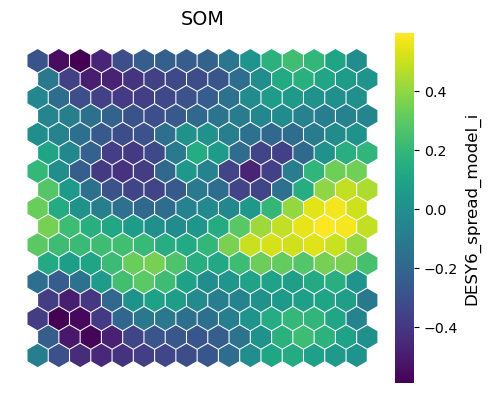

2025-05-01 23:00:33.909 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_15.png


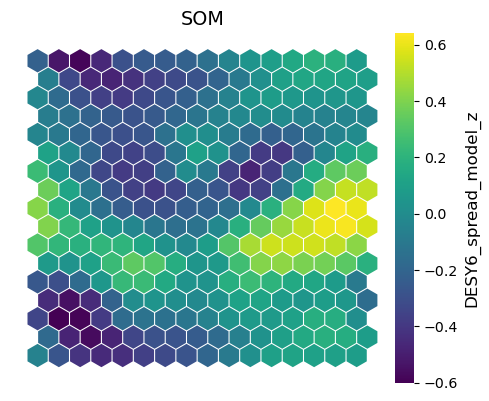

2025-05-01 23:00:34.255 | INFO     | simpsom.network:plot_map_by_feature:825 - Feature map will be saved to:
/data/mfonseca/soms/maps/./som_feature_16.png


In [27]:
for i in range(len(columns)):
    som.plot_map_by_feature(
        feature_ix= i,
        show=True,
        print_out=True,
        cbar_label=catalog_som_clean.columns[i],
    )

## Plot features after dewithening

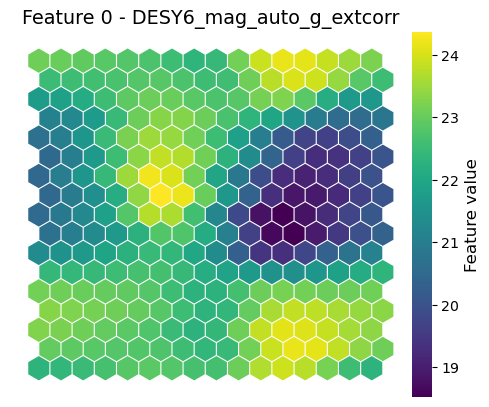

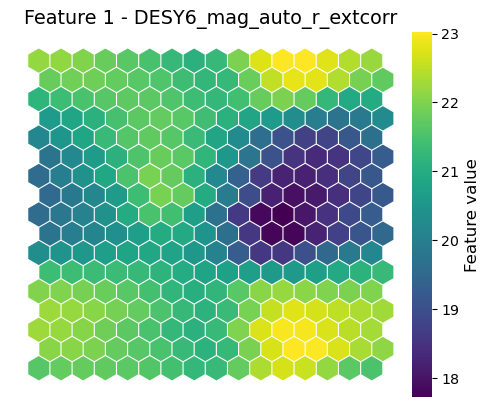

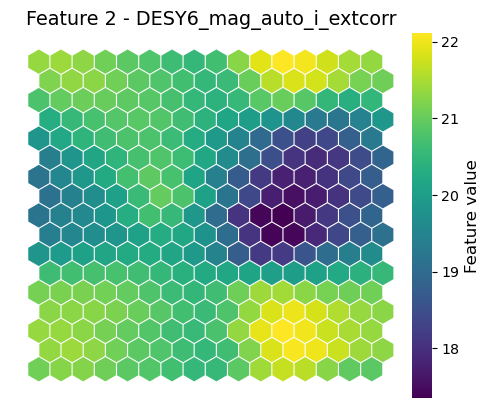

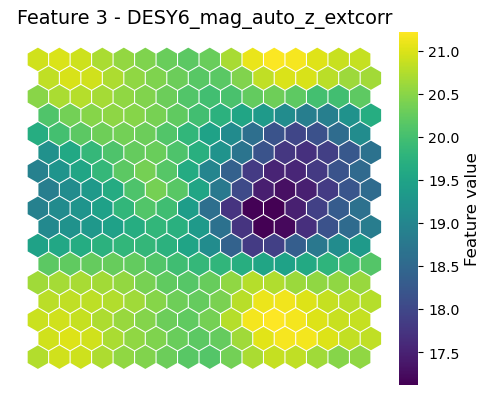

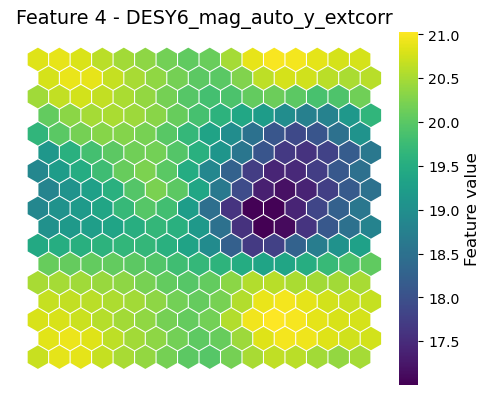

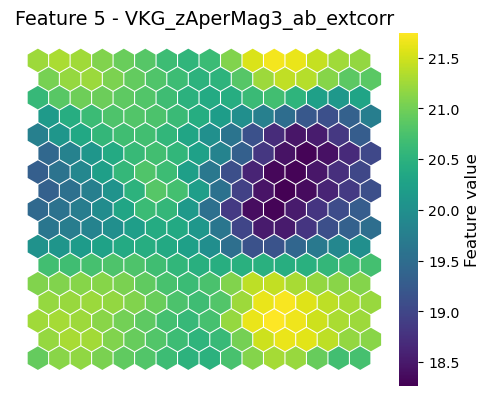

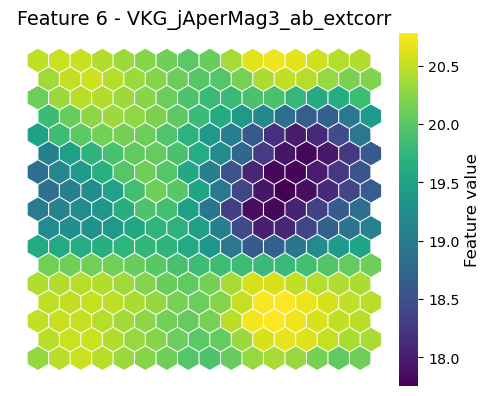

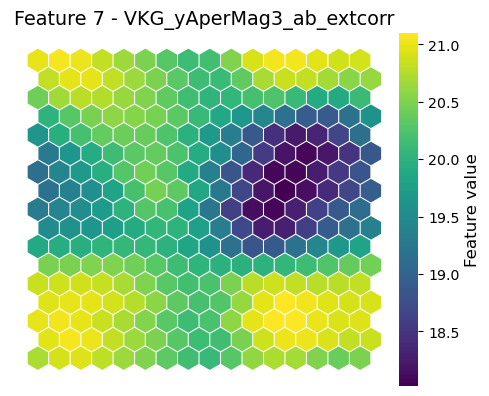

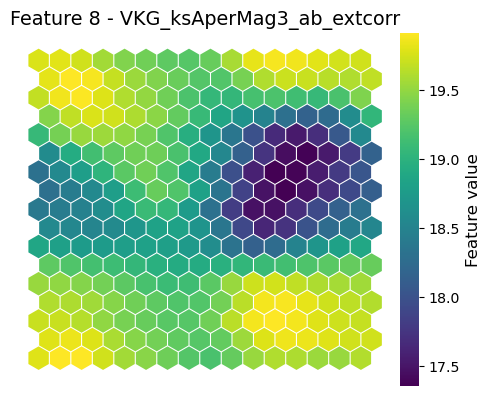

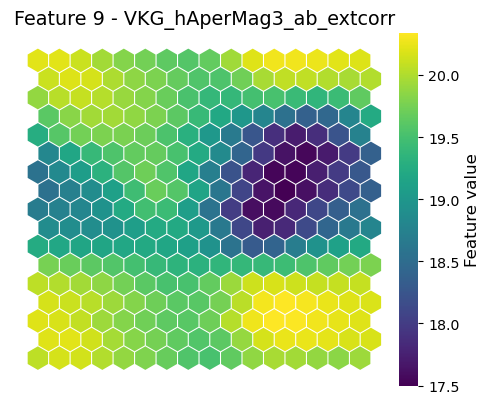

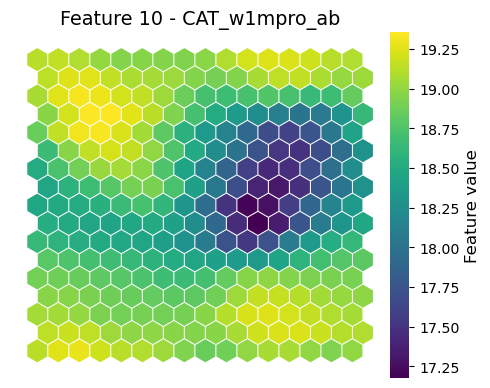

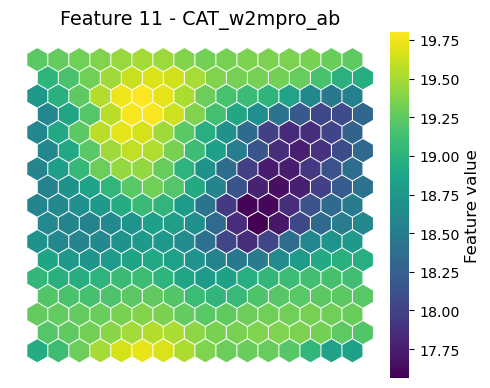

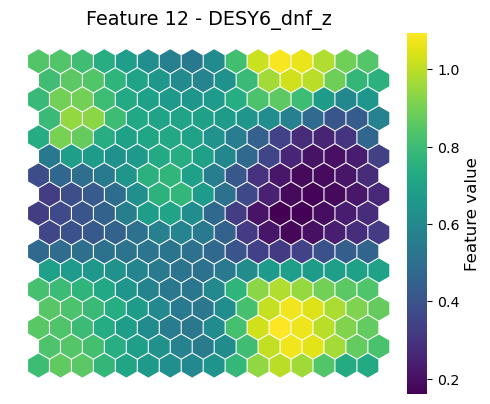

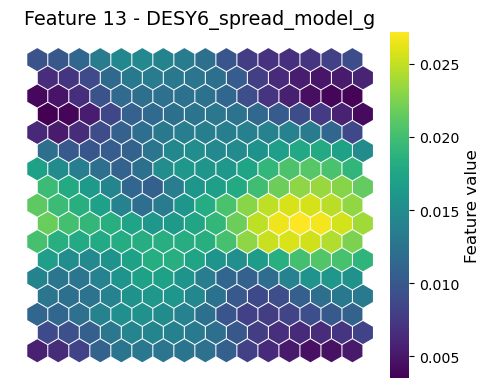

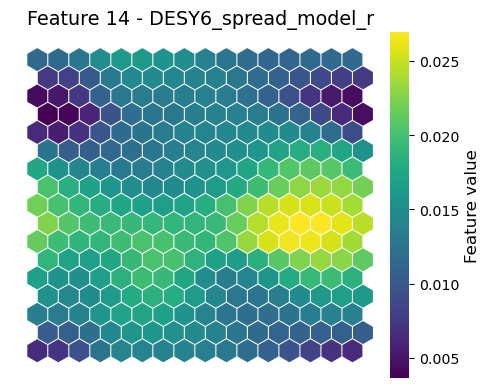

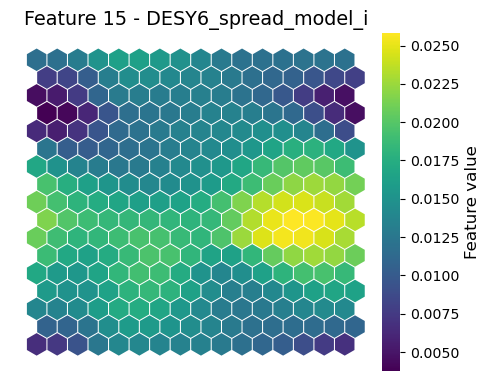

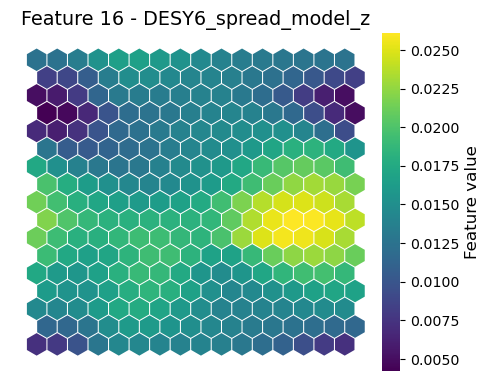

In [61]:
all_positions = [[node.pos[0], node.pos[1]] for node in som.nodes_list]
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(columns))] for node in som.nodes_list]

# convert back to the original feature space
weights_dewhitened = inverse_pca_whitening(data, all_weights)

for idx in range(len(columns)):
    weights_dewhitened_feature = [weights_dewhitened[row][idx] for row in range(len(weights_dewhitened))]
    
    hexagon = sps.polygons.Hexagons

    sps.plots.plot_map(
        all_positions,
        weights_dewhitened_feature,
        hexagon,
        title = f'Feature {idx} - {columns[idx]}',
        show = True,
        print_out = False
    )

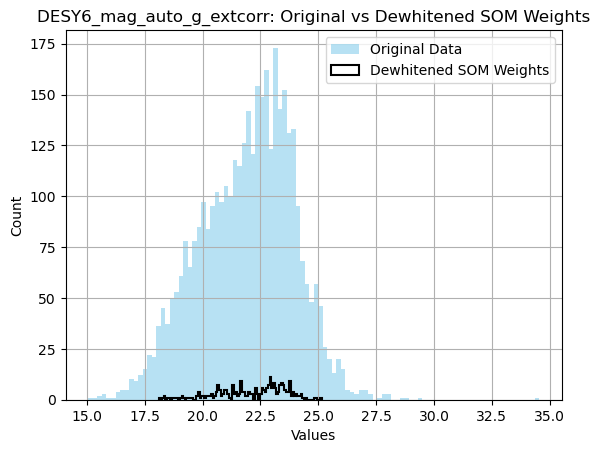

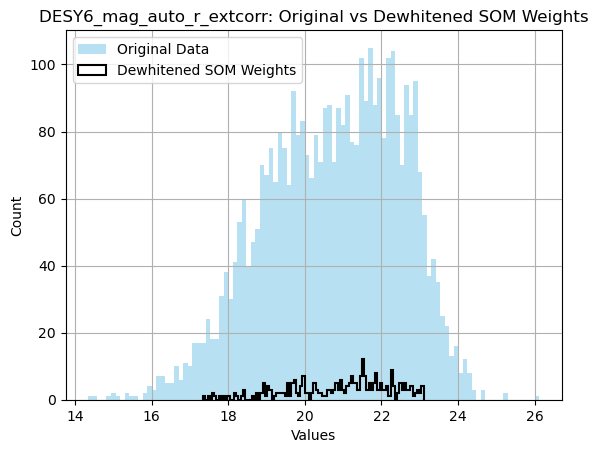

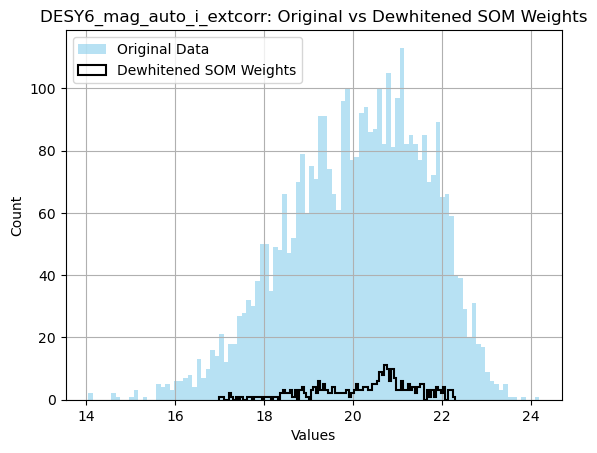

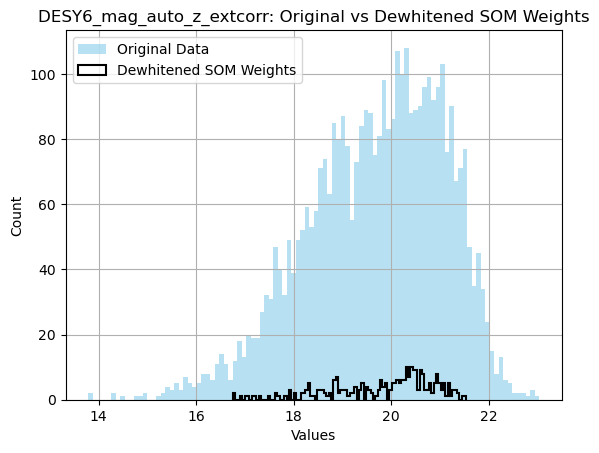

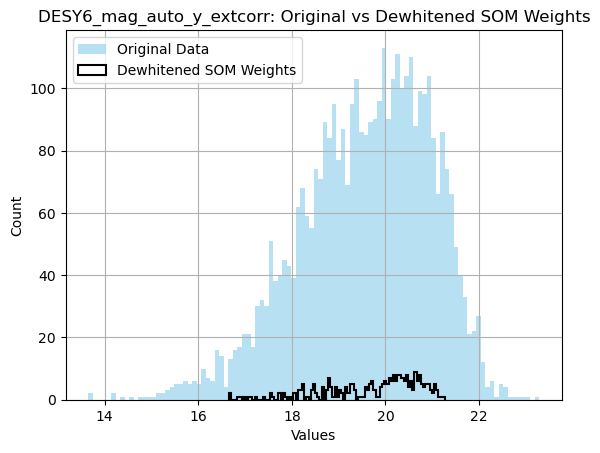

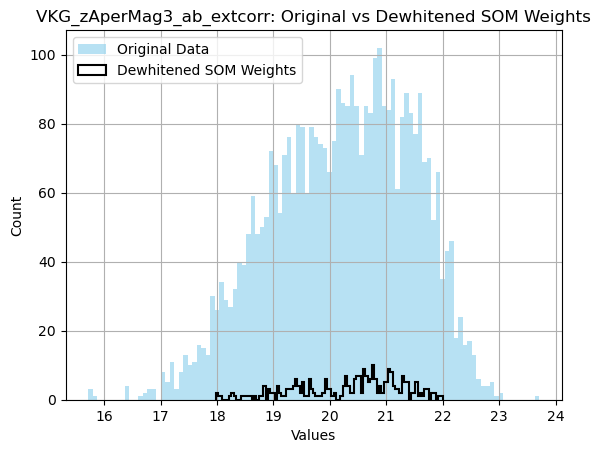

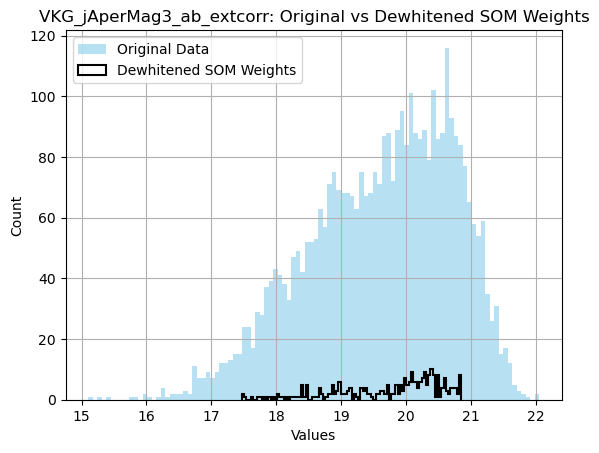

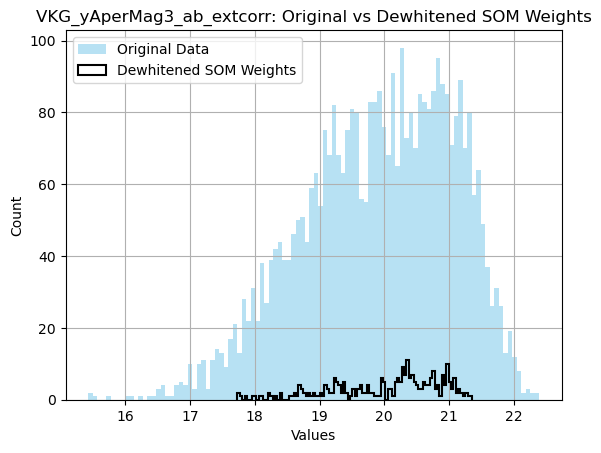

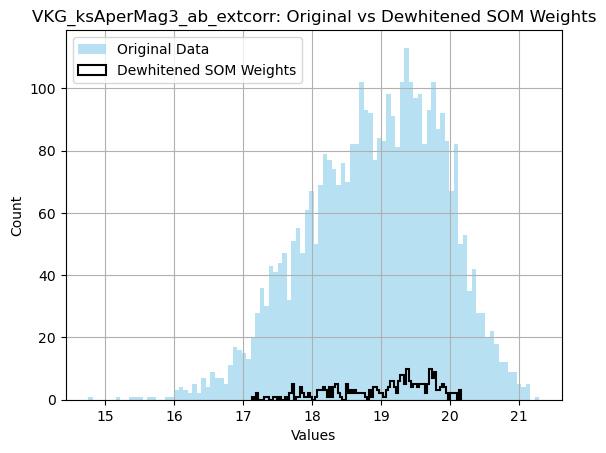

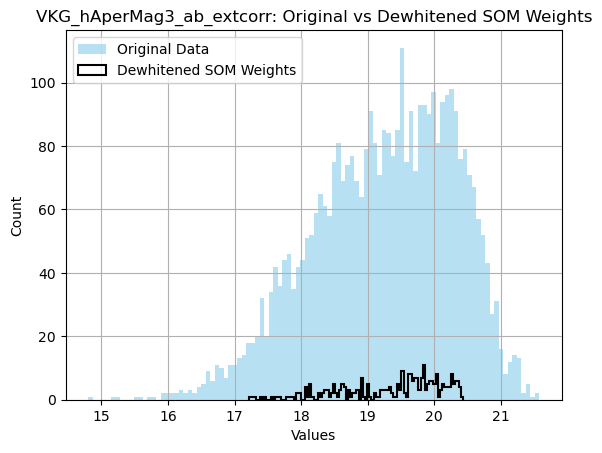

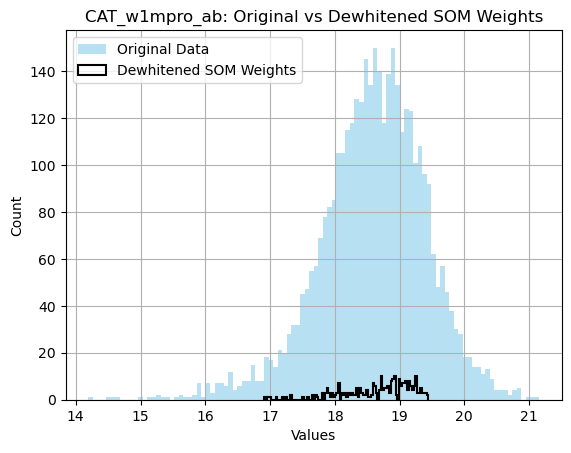

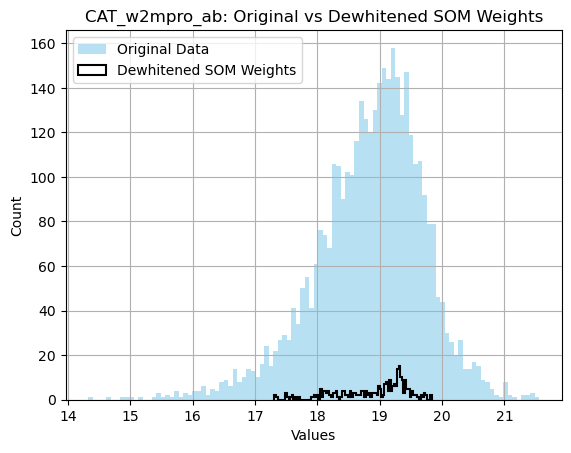

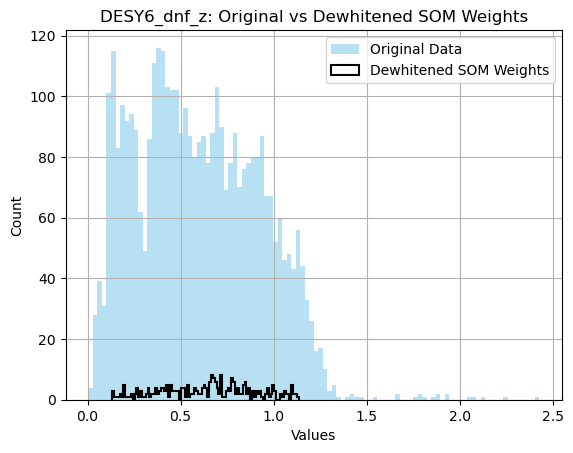

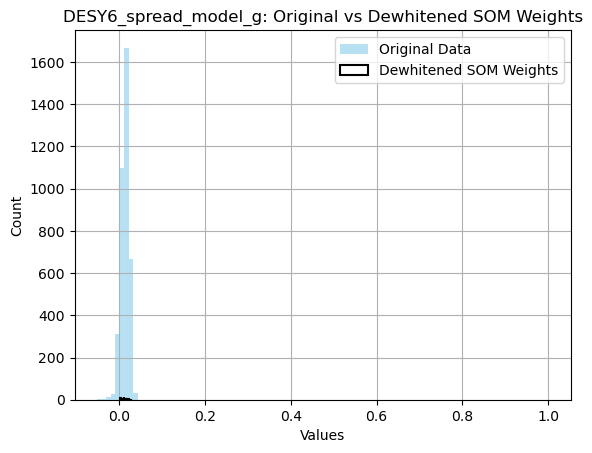

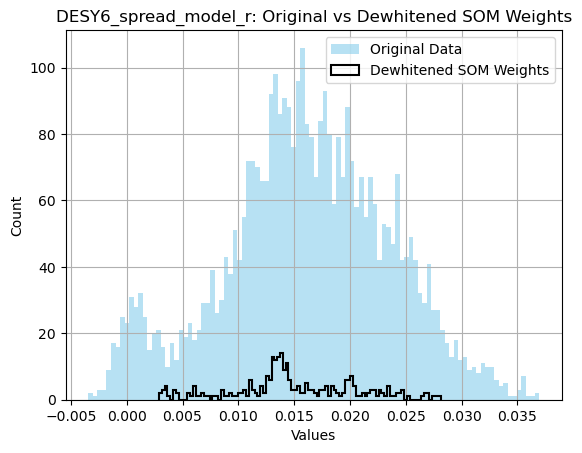

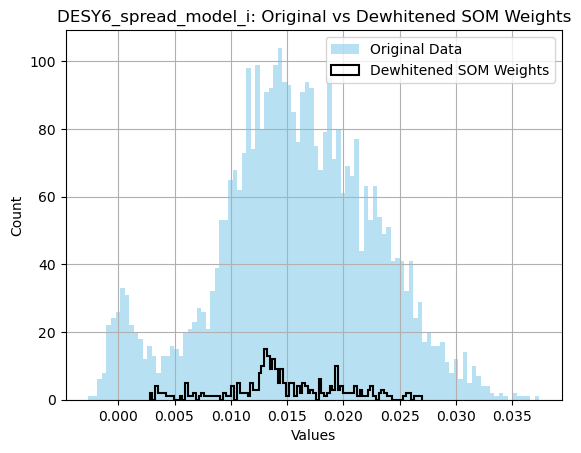

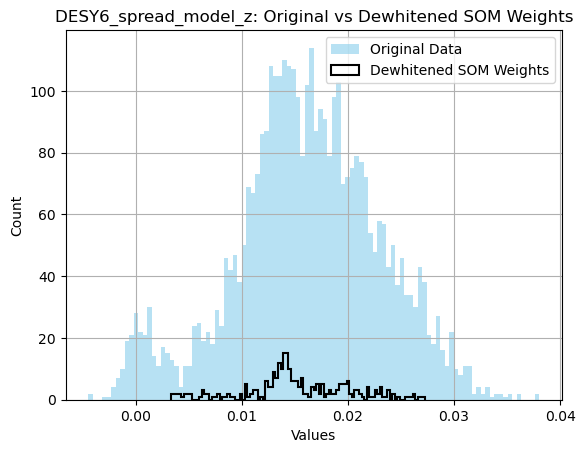

In [ ]:
# There a lot less som weights than data points, but the format seems to be the same

for i in range(len(columns)):
    # Histogram of the original data (filled bars)
    plt.hist(catalog_som_clean[columns[i]], bins=100, alpha=0.6, label='Original Data', color='skyblue')

    # Histogram of the dewhitened SOM weights (outlined bars)
    plt.hist([weights_dewhitened[row][i] for row in range(len(weights_dewhitened))], bins=100, histtype='step', linewidth=1.5, label='Dewhitened SOM Weights', color='black')

    plt.title(f'{columns[i]}: Original vs Dewhitened SOM Weights')
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Create a matplotlib figure
fig = plt.figure(figsize=(7, 7))

# Draw the SOM map using polygon tiling and color by the selected feature
ax = sps.polygons.Polygon.draw_map(fig, centers=all_positions, feature=weights_dewhitened_feature, cmap=plt.cm.viridis)

# Add a colorbar and labels
plt.colorbar(ax.collections[0], ax=ax, label=f'Feature {feature_idx} Value')
plt.title(f'SOM Colored by Feature {feature_idx}')
plt.xlabel("SOM X")
plt.ylabel("SOM Y")
plt.grid(True)
plt.show()

### Obtain the data values from each node